# Projet d'analyse de séries temporelles

En colaboration avec :

- [Paul Leydier](https://github.com/pleydier)

- [Damien Raimond](https://github.com/dams-lab/)

- [Wenceslas Sanchez](https://github.com/Orlogskapten)

---

Le but du projet est de:

- développer (sans aucun package R) des outils permettant de modéliser un modèle VAR généralisé à l'ordre p

- construire les fonctions de réponses aux chocs d'un modèle VAR d'ordre p

- et d'appliquer tout cela à l'analyse des dépendances entre les économies chinoise, américaine et de la Zone Euro.

Toutes les fonctions que nous avons développé sont généralisées pour l'ordre p, et sont commentées pour comprendre leurs inputs, et leur construction.

---

### Sommaire :

[Question 1](#1)

[Question 2](#2)

[Question 3](#3)

[Question 4](#4)

[Annexes](#a)

In [1]:
setwd("C:/Users/Wenceslas/Desktop/R/R_project/serie_temp/projet")

data= read.csv("Data.csv", head= TRUE, sep= ";", dec=",")
dates= as.Date(data[, 1], format= "%d.%m.%Y")
data[, 1] = NULL # on enleve les dates
data[, 4] = NULL # on enleve la dernière colonne
# On vérifie le typage
str(data)
# On a des factors au lieu de double
# on change donc le typage factor -> double
for (i in 1:3){
    data[, i] = as.double(levels(data[, i]))[data[, i]] / 100 # on en profite pour diviser par 100
}

data_matrix= as.matrix(data)
head(data)

'data.frame':	96 obs. of  3 variables:
 $ China   : Factor w/ 49 levels "10","10.1","10.2",..: 7 45 44 4 2 1 39 39 30 26 ...
 $ USA     : Factor w/ 44 levels "-2.8","-3","-3.3",..: 23 35 36 39 38 38 41 40 43 36 ...
 $ Eurozone: Factor w/ 49 levels "-0.4","-0.5",..: 23 26 29 30 31 36 38 44 47 41 ...


China,USA,Eurozone
0.109,0.026,0.012
0.094,0.040,0.015
0.092,0.041,0.018
0.103,0.044,0.019
0.101,0.043,0.020
0.100,0.043,0.025


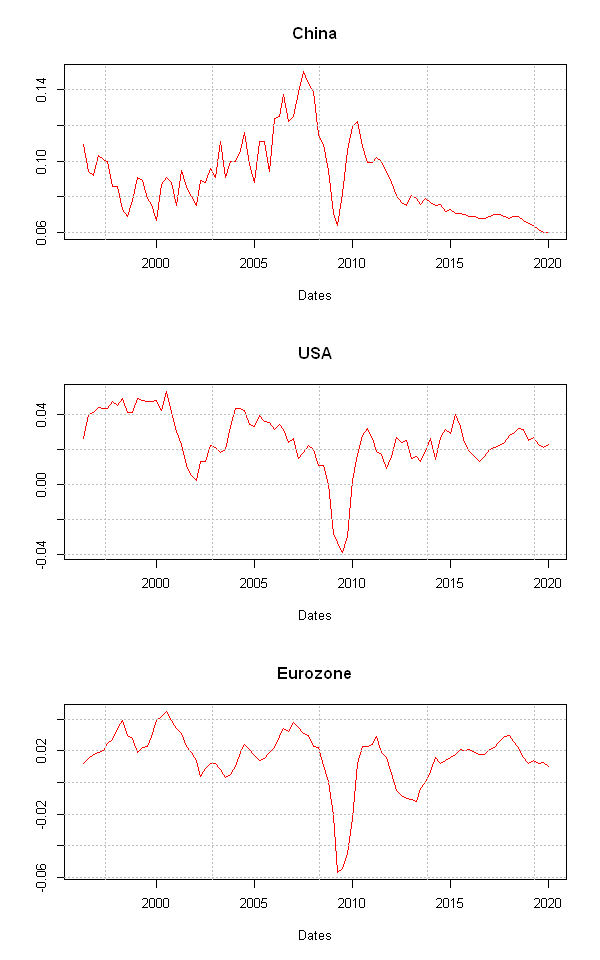

In [2]:
fig <- function(width, heigth){
# Permet de définir la taille d'un plot
# Equivalent à plt.figure(figsize= (width, heigth)) sur Python
     options(repr.plot.width= width, repr.plot.height= heigth)
}

fig(5, 8)
layout(matrix(1:3, 3, 1, byrow= T))

col_named= colnames(data) # récupère le nom des pays
for (i in 1:3){
    plot(dates, data[, i]
         , col= "red", main= col_named[i]
         , ylab= "", xlab= "Dates", type= "l")
    grid(col= "grey")
}

#### Remarque :

Voici-ci ci-dessus les dynamiques de nos trois séries de taux de croissance. Premier fait, on remarque que les séries Eurozone et USA ont la même forme, mais pas la même amplitude. On a donc deux économies dont les taux de croissance réagissent de la même manière ; ci-dessous on peut voir une corrélation de près de 0.7 pour ces deux séries.

Cela pourrait être important pour la suite de l'analyse, notamment pour comprendre la diffusion d'un choc d'un pays vers un autre.

In [3]:
print("Matrice de corrélation")
cor(data_matrix)

[1] "Matrice de corrélation"


,China,USA,Eurozone
China,1.00000000,0.03359704,0.1648283
USA,0.03359704,1.00000000,0.7340869
Eurozone,0.16482825,0.73408690,1.0000000


Autre point, mise à part la période de 2008-2012, il semblerais que les Etats-Unis et la Zone Euro aient des taux de croissance plutot stable entre 0 et 2% (4% pour les Etats-Unis). Ce n'est pas sans rappeler les théories à propos de la stagnation séculaire, même si selon Summers et Gordon les taux de croissance dans une telle situation devraient être bien plus faible (~0.5%).

Dernier point à propos de la Chine, depuis la crise de 2008 et sa reprise en 2011, on remarque une tendance à la baisse de son taux de croissance. En effet, il semblerait que les 10% de croissance annuel dont profitait jusque là la Chine soit une époque révolue, avec des taux qui pourraient converger vers ceux des pays développés (type Etats-Unis) d'ici quelques années. 
En effet, les taux de croissances exeptionnels de l'Empire du Milieu était dû à l'effet de rattrapage de son économie et la réduction de ses taux est probablement liée au fait que la Chine par rattraper les pays les plus développés.

<a id= "1"></a>

### 1). Explain what a VAR model and an impulse response function is.

Le modèle VAR permet d’analyser des séries temporelles de manière multivariées, en étudiant les dépendances linéaires au sein de toutes les séries que l'on considère. Il se distingue d'un modèle AR par cet aspect multivarié.

Pour expliquer une variable $X_t$, avec un modèle VAR d'ordre 1, nous allons utiliser la donnée de la période précédente telle que :

$$VAR(1): X_t= \phi_0 + \phi_1X_{t-1} + \epsilon_t$$
avec :
$$X_t= \begin{pmatrix}
chine\_growth_t\\
USA\_growth_t\\
Zone€\_growth_t
\end{pmatrix}$$

A l'ordre p on a:
$$VAR(p): X_t= \phi_0 + \phi_1X_{t-1} + \phi_2X_{t-2} + ... + \phi_pX_{t-p} + \epsilon_t$$
C'est-à-dire qu'un VAR d'ordre p permet de considérer un lien entre nos données en t et les données observées jusqu'en t-p.

Ce qu'il y a de magique avec un modèle VAR, c'est qu'on peut le transformer et faire disparaître les séries $X_{t-p}$ pour ne faire apparaître que les chocs. L'idée derrière cette transformation est de pouvoir expliquer les valeurs de $X_t$ en fonction des chocs passés. En économie, c'est un concept utile par exemple pour voir comment un choc de demande se propage à travers les séries de taux de croissance, taux d'intérêt et de taux de chômage ; car en économie les variables macroéconomiques ne sont que rarement indépendantes les unes des autres, et donc observer et comprendre l'impact d'un choc provenant d'une série sur les autres est essentiel.

Dans notre projet, nous avons les taux de croissance de la Chine, des Etats-Unis et de la Zone Euro de 1996 à fin 2019. Avec la mondialisation, et les connexions de plus en plus grandes entres les économies, il est intéressant de voir comment un choc de croissance dans un pays, pourrait en atteindre un autre et surtout, pendant combien de temps. Ce n'est pas sans rappeler la situation actuelle et la crise mondiale du COVID qui touche toutes nos économies. Mais on aura l'occasion d'en parler plus longuement dans la dernière question.

Pour coder un VAR d'ordre p, il nous a fallu repenser la construction du dataset, et de son interaction avec les coefficients à optimiser.

Imaginons que l'on doive construire un **VAR d'ordre 2**. Le dataset que nous devrions utiliser pour le construire ressemblerait à ceci :


| t | Chine | USA | Zone€ | | t - 1 | Chine | USA | Zone€ | | t - 2 | Chine | USA | Zone€ |
| --- | --- | --- | --- | | --- | --- | --- | --- | | --- | --- | --- | --- |
| 1 | 0.109 | 0.026 | 0.012 | |  |  |  |  | |  |  |  |  |
| 2 | 0.094 | 0.04 | 0.015 | | 1 | 0.109 | 0.026 | 0.012 | |  |  |  |
| 3 | 0.092 | 0.041 | 0.018 | | 2 | 0.094 | 0.04 | 0.015 | | 1 | 0.109 | 0.026 | 0.012 |
| 4 | 0.103 | 0.044 | 0.019 | | 3 | 0.092 | 0.041 | 0.018 | | 2 | 0.094 | 0.04 | 0.015 |
| 5 |  |  |  | | 4 | 0.103 | 0.044 | 0.019 | | 3 | 0.092 | 0.041 | 0.018 | 
| 6 |  |  |  | | 5 |  |  |  | | 4 | 0.103 | 0.044 | 0.019 |


avec notre première série $X_t$ à prédire, suivi des 2 autre séries nécessaires pour construire un VAR d'ordre 2. On se rend compte que les 2 premières lignes de $X_t$ ne sont pas observables si on souhaite construire ce VAR étant donné le vide des 2 premières lignes de la série $X_{t-2}$. Il faudra donc modéliser uniquement avec les observations à t = 3 et t = 4. Avec un ordre p, il faudrait alors modéliser sur m-p observations, avec m le nombre d'observation du dataset.

On récupère chaque série lagguée indépendament, et on la multiple au set de coefficient $\phi$ qui lui est associé pour pouvoir calculer la valeur de notre prédiction $\tilde{X_t}$. Puis on calcule l'erreur de prédiction en redimensionnant bien $X_t$. Le but étant de minimiser l'erreur, on va chercher à maximiser la log vraisemblance en passant par une fonction de densité gaussienne multivariée pour chercher les bons paramètres $\phi$.

Dernier point, le set de paramètre $\phi$ que l'on rentre initialement est généré aléatoirement ; il n'est pas égal à un vecteur constitué de 0. Cette solution permet, parfois, d'augmenter la vitesse de convergence de notre modèle, voire de le faire converger.

In [4]:
mvnorm<-function(X,mu,sigma)
{
    # Permet de calculer la fonction densité
        # X représente un vecteur 1xn
        # Mu représente un vecteur 1xn
        # Sigma une matrice nxn
    A=(2*pi)^(ncol(sigma)/2)
    B=det(sigma)^(1/2)
    C=-1/2*t(X-mu)%*%solve(sigma)%*%(X-mu)
    D=exp(C)
    return(1/(A*B)*D)
}

# test
mu= apply(data_matrix,2,mean)
sigma= diag(3)
mvnorm(data_matrix[2,],mu,sigma)

0.06348571


In [5]:
VAR_loglik_p<-function(para, vectored)
{
    # Permet de calculer la log vraisemblance d'un modèle VAR(p)
        # para désigne un vecteur de (n + n*n*p) contenant les paramètres du modèle
        # vectored correspond à un vecteur contenant le datatset, l'ordre du VAR, et les dimensions du datatset 
    
    # Récupère l'information du vecteur
    stocked= tail(vectored, 3)
    p= stocked[3]
    n= stocked[1]
    m= stocked[2]
    X= matrix(vectored[1: (length(vectored) - 3)], m, n )
    
    # Extraction des intercepts
    phi_0= para[1:n]
    # E désigne la valeur X calculée à l'aide du modèle 
    # On construit en amont E, ce qui nous permet d'ajouter les intercepts, et de bien définir
    # sa dimension
    E= matrix(phi_0, m-p, n, byrow= T)
    
    # Si l'ordre du VAR = 3, alors il y aura 3 matrices de dimension nxn
    # On récupère par itération les coefficients qui sont associés à chaque matrice (en premier 
    # la matrice associée aux données avec le premier retard, puis le deuxième etc.)
    for (i in 1:p){
        # Récupère les coefficients de la matrice du retard i
        phi_i= matrix(para[((n*n*i + n) -(n*n) + 1):(n*n*i + n)], n ,n)
        # Pour la matrice phi_1, les coefficients phi1_11, phi1_12, phi_13 dans le cas d'une var
        # avec 3 séries, ne seront pas en ligne comme dans une représentation matricielle
        # mais seront stockés dans la première colonne !!

#         E= E[-1,] + X[-c((m-i+1):m),]%*%phi_i # enlève le bas
#         E= E[-dim(E)[1],] + X[-c((m-i+1):m),]%*%phi_i # enlève le bas
        
        # On fait le calcul phi_p . , mais comme les séries de X sont stockées en ligne
        # et que les coefficients sont sotckés en colonne, on doit faire X . phi_p
        # On enlève une partie de la matrice (le bas) qui dépend de l'ordre sur lequel on itère
        # cf le markdown ?
        phi_compute= X[-c((m-i+1):m),]%*%phi_i # enlève le bas de la matrice X pour associer les bons retards
        
        if (i == p){
            E= E + phi_compute
        }
        else {
            E= E + phi_compute[-c(1:(p-i)),] # enlève le haut pour que les retards fit bien avec E et X
        }
    }
    
    # Pour concorder avec le retard max (= ordre p), on doit se séparer des p premières lignes de X
    residus= X[-c(1:p), ] - E
    sigma= var(residus)
    
    log_lik= 0
    
    # Calcul de la log vraisemblance
    # On commence la boucle à p+1 et non à 1 pour simplifier le raisonnement (permet de
    # sélectionner les données X à partir de i)
    # Mais on aurait pu commencer à 1 et on aurait modifier l'indice dans X et E
    for (i in (1+p):m){
        temp= mvnorm(X[i, ], E[(i-p),], sigma) # E est pris à partir de p car j'ai enlevé p lignes
                                                # dans le processus précédent
        temp= log(temp)
        log_lik= log_lik - temp
    }
    
    return(log_lik)
}

# test
n= ncol(data_matrix)
p_order= 2 # ordre 2

VAR_loglik_p(numeric(n + n*n*p_order)
             , c(data_matrix, n, nrow(data_matrix), p_order))

239.9798


In [6]:
# Optimisation test pour VAR(2)
n= ncol(data_matrix)
p_order= 2 # VAR d'ordre 2

estimation_auto= function(X= data_matrix, p= p_order, num= n){
    # Permet de sortir les résultats de l'optim (neg log vraissemblance et coef)
        # X désigne le dataset
        # p l'ordre de la VAR à calculer
        # n le nombre de série du VAR
    
    # On utilise dans un premier temps des poids aléatoires compris entre 0 et 1
    # mais si on a un soucis on utilise un set de paramètres avec que des 0
    # (dans notre cas, on a parfois eu des problèmes)
    tryCatch({
    weight= round(runif(num + num*num*p, 0, 1), 1)
    para= weight/sum(weight) # permet de ne pas faire bugger l'optim
        
    estimation= optim(para, fn= VAR_loglik_p
                  , vectored= c(X, ncol(X), nrow(X), p)
                  , method= "BFGS")
    print("Initialization with random parameters")
        
    return (estimation)
    }, error= function(e) # au cas où
            {
            # Set de paramètres 0
            para= numeric(num + num*num*p) 
            estimation= optim(para, fn= VAR_loglik_p
                  , vectored= c(X, ncol(X), nrow(X), p)
                  , method= "BFGS")
            print("Initialization with zero values for parameters")
    return (estimation)
            })
}

# test
estimation_auto(X= data_matrix, p= p_order, num= n)

[1] "Initialization with random parameters"


$par
 [1]  0.0112488235  0.0068253982  0.0004074698  0.8991054504 -0.0154554913
 [6]  0.0490498896  0.0821082538  1.0175307065  0.2876107952  0.1425288284
[11]  0.4026551302  1.2037019479 -0.0059062504 -0.0228887314 -0.1170929565
[16] -0.1171241413 -0.1362357960 -0.3417400425 -0.1434981628 -0.2889110164
[21] -0.4014904051

$value
[1] -1014.176

$counts
function gradient 
     265       68 

$convergence
[1] 0

$message
NULL

<a id= "2"></a>

### 2). Using information criterions, estimate the lag to be used with the three data series for your VAR model. What do you think of this lag?

Comme il est possible de générer p VAR, il nous faut déterminer l'ordre qui est le plus intéressant pour  modéliser notre série de données. Dans ce but, nous allons utiliser les fonctions précédentes pour construire tous les modèles VAR de l'ordre 1 à 10. 
Pour comparer tous ces modèles, nous allons utiliser des critères d'informations (AIC, BIC et HQ), qui permettent de prendre en compte à la fois la performance d'un modèle (la valeur de la log vraisemblance) mais aussi sa complexité (le nombre de paramètres). En effet, il est très simple d'avoir une bonne log vraisemblance en augmentant le nombre de paramètres. Mais le modèle devient trop spécifique à notre jeu de données.
Dans le cas d'un VAR, si on prend un ordre très élevé, le nombre de paramètres sera alors plus grand qu'avec un VAR d'ordre 1. En effet, si n représente le nombre de séries, le nombre de paramètres d'un VAR d'ordre p sera alors de $n*n*p + n$.

En cherchant à minimiser les critères d'informations, on trouve le modèle qui a un bon équilibre entre performance et complexité. 

Dans notre cas, on a représenté la valeur de ces critères dans le tableau ci-dessous.

In [7]:
# On va chercher à savoir l'ordre du VAR que nous devons choisir
cb_de_var= 10

formule_generale= function(p, log_lik, n, m, g){
    # Permet de calculer tous les critères d'informations en fonction de g
        # P désigne l'ordre du VAR
        # log_lik désigne la log vraisemblance du modèle calculée
        # n le nombre de séries (permet de calculer le nombre de paramètres du modèle)
        # m le nombre d'observations
        # g correspond à la fonction d'information sélectionnée
    base= -(2*log(log_lik))
    k= n + n*n*p # nombre de param
    return (base + (k*g))
}

bic_g= function(m){
    # Permet de calculer la fonction g pour le critère BIC
    return (log(m))
}

hq_g= function(m){
    # Permet de calculer la fonction g pour le critère HQ
    return (log(bic_g(m)))
}

# Préparation
n= ncol(data_matrix)
order_var= c(1:cb_de_var)
aic= c()
bic= c()
hq= c()
# On va itérer sur tous les ordres p sélectionnés et calculer les critères d'informations
for (i in order_var){

    m_in= nrow(data_matrix) - i # à chaque ordre p, le dataset diminue de - p
    estimated= estimation_auto(X= data_matrix, p= i, num= n)
    log_like_estimated_i=  -1*estimated$value # la valeur sortie est la negative log likelihood
                                            # donc on multiplie par -1
    aic= c(aic, formule_generale(i, log_like_estimated_i, n, m_in, g= 2))
    bic= c(bic, formule_generale(i, log_like_estimated_i, n, m_in, g= bic_g(m_in)))
    hq= c(hq, formule_generale(i, log_like_estimated_i, n, m_in, g= hq_g(m_in)))
}

[1] "Initialization with random parameters"
[1] "Initialization with random parameters"
[1] "Initialization with random parameters"
[1] "Initialization with random parameters"
[1] "Initialization with random parameters"
[1] "Initialization with random parameters"
[1] "Initialization with random parameters"
[1] "Initialization with random parameters"
[1] "Initialization with random parameters"
[1] "Initialization with random parameters"


In [8]:
# Construction du dataset pour représenter la valeur des critères en fonction de l'ordre
df_which_order= data.frame(p_order= order_var
                          , AIC= aic
                          , BIC= bic
                          , HQ= hq)
df_which_order

p_order,AIC,BIC,HQ
1,10.20451,40.85103,4.396259
2,28.15634,81.56553,17.943039
3,46.16535,122.14333,31.504218
4,64.17198,162.52173,45.019376
5,82.17881,202.70007,58.490222
6,100.18565,242.67480,71.915647
7,118.19981,282.44981,85.302036
8,136.19667,321.99694,98.623805
9,154.17525,361.31153,111.878950
10,172.18117,400.43546,125.112056


Pour rappel, le meilleur des modèles est celui qui a le critère le plus faible. Dans notre cas, nous avons de la chance car tous les critères nous ramènent à la même conclusion : le modèle VAR d'ordre 1 est le meilleur.
C'est à dire qu'un lag de 1 nous permet au mieux de modéliser $X_t$.

On doit vous avouer qu'on s'attendait à obtenir un lag de 2 ou de 4, étant donné la nature de nos séries. En effet, nous avons à modèliser des taux de croissance de pays ; il est probable que le taux de croissance du premier trimestre impacte celui du troisième. 
Aussi, on pensait que chacune des séries étaient autocorrélées sur plusieurs périodes (6 mois voire 1 an). Et quand on trace notre autocorrélogramme, pour chaque série séparément, on se rend compte que c'est bien le cas : on observe de fortes autocorrélations, significative jusqu'à 5 périodes, c'est à dire 1 an et 1 trimestre.

En se renseignant un peu [_$^{1}$_](https://stats.stackexchange.com/questions/207156/autocorrelation-of-var-residuals) , on s'est rendu compte que les critères d'informations ne cherchent pas à minimiser l'autocorrélation ; ils déterminent le modèle qui décrit bien nos données, mais pas un modèle qui les décrit parfaitement. Dans notre cas, il est probable que chercher à supprimer l'autocorrélation passe par une trop forte hausse de la complexité. C'est pourquoi les critères nous amènent à considérer le plus petit des ordres pour le modèle.

Par conséquent, si notre but est de générer un modèle pour faire de la prédiction, un lag de 1 est parfait car c'est le modèle qui nous permet au mieux de gérer performance et overfitting. Mais si notre but est d'expliquer, et que l'autocorrélation est un problème pour notre analyse économique, alors il faudrait choisir un autre moyen pour sélectionner le bon ordre pour un VAR.

Pour la suite du projet, on construira un VAR d'ordre 1 (c'est à dire que l'on suit les indications des critères d'informations).

---
$^{1}$[Stats StackExchange](https://stats.stackexchange.com/questions/207156/autocorrelation-of-var-residuals)

<a id= "3"></a>

### 3). Simulate impact

Même si nous allons simuler l'impact de taux de croissance négatifs avec un VAR d'ordre 1, nous avons cherché à généraliser nos fonctions à tous les VAR possibles.

Le problème, c'est que plus on modèlise de lag, plus la construction d'une fonction de réponse généralisée se complexifie. En effet, on pourrait imaginer des chocs différents sur plusieurs périodes comme par exemple au premier et au dernier trimestre. Dans notre cas, vu que le choc n'arrive qu'en t, nous n'avons pas besoin d'aller aussi loin dans la construction, mais nous avons quand même proposé une solution à ce problème.

La solution que nous avons trouvé est de tranformer n'importe quel VAR p en un VAR d'ordre 1. Voici comment se présente notre transformation :
Si on a $X_t$ nos n séries de données, $\phi_p$ notre matrice de coefficients associée aux séries lagguées à p périodes et $\epsilon_t$ le vecteur d'erreur de prédiction, exprimés comme suit:

$$X_t= \begin{pmatrix}
chine\_growth_t\\
USA\_growth_t\\
Zone€\_growth_t
\end{pmatrix}$$
et
$$\phi_{p}=\begin{pmatrix}
\phi_{1,1,p}&\phi_{1,2,p}&...&\phi_{1,n,p}\\
\phi_{2,1,p}&\phi_{2,2,p}&...&\phi_{2,n,p}\\
...&...&...&...\\
\phi_{n,1,p}&...&...&\phi_{n,n,p}
\end{pmatrix}$$
et
$$\epsilon_{t}=\begin{pmatrix}
\epsilon_{chine_t}\\
\epsilon_{usa_t}\\
\epsilon_{zone€_t}
\end{pmatrix}$$
$$$$
alors notre représentation d'un VAR p en VAR 1 se fait de la manière suivante:
$$$$
$$\begin{pmatrix}
X_t\\
X_{t-1}\\
...\\
...\\
X_{t-p+1}
\end{pmatrix}
=\begin{pmatrix}
\phi_{1}&\phi_{2}&...&...&...&\phi_{p}\\
1\\
0&1&...\\
...\\
0&...&...&1&...&0
\end{pmatrix}
\begin{pmatrix}
X_{t-1}\\
X_{t-2}\\
...\\
...\\
X_{t-p}
\end{pmatrix}
+\begin{pmatrix}
\epsilon{t}\\
0\\
...\\
...\\
0
\end{pmatrix}$$
$$$$
Etant donné que l'on sait construire la fonction de réponse généralisée à partir d'une matrice $phi_1$ dans le cas d'un VAR 1, on peut généraliser sa construction avec cette matrice (ci-dessus). Avec cette construction on pourra alors simuler des chocs sur plusieurs périodes à la fois. On a donc développé cette manière d'exprimer un VAR d'ordre p. Néanmoins, nous n'avons pas fait en sorte de pouvoir générer des chocs sur plus d'une période. Ainsi, pour construire la fonction de réponse, nous avons uniquement utilisé $\phi_1$ étant donné que le choc apparaît à la première période.

In [9]:
# le but est de construire une matrice tel que en colonne on a
# Calculer l'impact d'un choc avec un VAR p est compliqué
# On va chercher à transformer notre VAR p en un VAR 1

transformation_Xt_varp= function(X, p_order){
    # Permet de transformer le dataset initial pour permettre la permutation d'un VAR p à un VAR 1
        # X désigne notre dataset
        # p_ordre désigne l'ordre du VAR
    n= ncol(X)
    m= nrow(X)
    
    # Si on a un VAR 1, alors on ne change pas notre dataset
    if (p_order == 1){
        return (X)
    }
    else {
        tested= X
        stocked= X[-c((m-p_order+1):m), ] # série initiale Xt
        # Le but est de pouvoir coller les séries de données Xt, Xt-1, ... , Xt-p
        # On a donc un dataset de dimension (m-p)x(n*p)
        for (i in c(1:p_order)){
            tested_copy= tested[-c(1:i), ]
            ajout_p_col= tested_copy[-c((m-p_order+1):m), ]
            
            stocked= cbind(ajout_p_col, stocked)
        }
        return(stocked)
    } 
}

# # Test
# p_order= 4
# test= transformation_Xt_varp(data_matrix, p_order)
# head(test)

In [10]:
phi_zero_compute= function(X, p_order){
    # Permet de sortir la matrice d'intercept
    n= ncol(X)
    m= nrow(X)

    estimation_good_var= estimation_auto(X= X, p= p_order, num= n)
    para= estimation_good_var$par
    phi_zero= para[1:n]
    
    return (phi_zero)
}


phi_transforma= function(X, p_order){
    # Permet d'assembler toutes les matrices phi qui nous permettent la transformation VAR p -> VAR 1  
    n= ncol(X)
    m= nrow(X)

    estimation_good_var= estimation_auto(X= X, p= p_order, num= n)
    para= estimation_good_var$par
    
    # On ne fait pas de transformation si on a un VAR d'ordre 1
    # On retourne uniquement les paramètres
    if (p_order == 1){
        phi_uno= matrix(para[(n+1):length(para)],n,n)
        return (phi_uno)
    }
    else {
        # Assemblage des coefficients
        # On va stack de manière horizontale les matrices de coef phi 1 à phi p
        stock_phi= matrix(numeric(n*n), n, n)
        for (i in 1:p_order){
            phi_i= matrix(para[((n*n*i + n) -(n*n) + 1):(n*n*i + n)], n ,n)
            stock_phi= rbind(stock_phi, phi_i)
        }

        stock_phi= stock_phi[-c(1:n), ]
        # On va combler les trous pour fiter notre matrice de coef aux nouveaux set données
        # calculé transformation_Xt_varp
        # La matrice de coef sera de dimension (n*p)x(n*p)
        dim_n_p= n*p_order
        identity_mat= diag(dim_n_p-n) # permet lors du calcul X . phi d'afficher
        # Xt-1 = Xt-1 , Xt-2 = Xt-2
        zero_mat_ligne= matrix(numeric((dim_n_p - n)*n), n, (dim_n_p - n))

        stock_phi= cbind(stock_phi, rbind(identity_mat, zero_mat_ligne))

        return (stock_phi)
    }
}

phi_zero_transforma= function(X, p_order){
    # Permet de redéfinir la matrice phi 0 (intercept) avec le dataset de transformation_Xt_varp
        # X correspond au dataset (dimention m*n)
        # p_order correspond à l'odre du VAR
    
    # Cas particulier dans le cas d'un VAR 1, on ne fait pas de transformation
    if (p_order == 1){
        return (phi_zero_compute(X, 1))
    }
    else {
        phi_zero= phi_zero_compute(X, p_order)
        phi_matrice= phi_transforma(X, p_order)
        diff_dim_col= ncol(phi_matrice) - length(phi_zero)
        # On comble la matrice avec des 0 à gauche
        zero_comble= matrix(numeric((diff_dim_col*nrow(phi_matrice)))
                                     , nrow(phi_matrice), diff_dim_col)
        
        phi_zero_new= cbind(matrix(phi_zero, nrow(phi_matrice), length(phi_zero), byrow= T)
                            , zero_comble)
        
        return (phi_zero_new)

    }
}

# # test
# p_order= 2
# phi_transforma(data_matrix, p_order)

In [11]:
error_transformation= function(X, p_order, stock_phi, phi_zero){
    # Permet de calculer l'erreur. Cette fonction permet de prendre en considération
    # la structure du dataset d'un VAR p
    n= ncol(data_matrix)
    m= nrow(data_matrix)
    dim_n_p= n*p_order
    
    if (p_order == 1){
        calcul_value= X[1:(m-1), ]%*%stock_phi + matrix(phi_zero, (m-1), n, byrow= T)
        errors= X[-1, ] - calcul_value
        
        return (errors)
    }
    else {
        test= transformation_Xt_varp(X, p_order)
        # enlève les 3 première colonnes qui sont t et pas t-1
        train= test[, -c(1:n)]
        # on a enlevé la dernière pour avoir t à t -p +1
        true_vals= test[, -c((dim_n_p + 1):(dim_n_p + n))]
        
        calcul_value= train%*%stock_phi + matrix(phi_zero[1, ]
                                                 , nrow(train), ncol(phi_zero), byrow= T)

        # on calcule l'erreur
        errors= true_vals - calcul_value

        return (errors)
    }
    
}

# # test
# p_order= 1
# stock_test_phi= phi_transforma(data_matrix, p_order)
# phi_zero= phi_zero_transforma(data_matrix, p_order)
# head(error_transformation(data_matrix, p_order, stock_test_phi, phi_zero))

In [12]:
compute_choleski_p= function(X, error, p_order){
    # Permet de récupérer la matrice triangulaire selon la factorisation de choleski
        # X désigne le dataset
        # error désigne la matrice d'erreur
        # p_order désigne l'ordure du VAR
    n= ncol(X)
    if (p_order == 1){
        sigma= var(error)
    } else {
        error_resized= error[, -c((n+1):dim(error)[1])]
        sigma= var(error_resized)
    }
    p= t(chol(sigma))
    return (p)
}


In [13]:
irf_compute= function(X, p_order, phi_matrix, horizon, vecteur_choc, p){
    # Permet de calculer la réponse à un choc
    # on récupère la première matrice phi pour calculer notre choc étant donné 
    # que le choc n'a lieu qu'à une période
    IRF= c()
    n= ncol(X)
    e= vecteur_choc
    
    # Cas spécial pour un VAR 1
    if (p_order == 1){
        for (i in 1:horizon){
            phi= phi_matrix^i
            temp= phi%*%p%*%e
            IRF= cbind(IRF, temp)
        }
    } else {
        # On récupère la matrice phi 1 
        new_phi= stock_test_phi[ ,-c((n+1):dim(stock_test_phi)[1])]
        new_phi_first= new_phi[c(1:n), c(1:n)]

        for (i in 1:horizon){
            phi= new_phi_first^i
            temp= phi%*%p%*%e
            IRF= cbind(IRF, temp)
        }
    }
    
    return (IRF)
}

# test
# horizon= 4
# e= c(0, -0.05, 0)
# p_mat= compute_choleski_p(computed_error, p_order)
# irf_compute(data_matrix, p_order, stock_test_phi, horizon, e, p_mat)

In [14]:
plot_irf= function(X, IRF){
    # Permet de plot nos IRF
        # X désigne notre dataset
        # IRf repésente la matrice de dimension nxhorizon des chocs pour 
        # chaque série (n) sur les différentes périodes (horizon)
    n= ncol(data_matrix)
    
    # Si le nombre de colonne est impair, alors j'ajoute une case vide dans layout
    if ((n %% 2) == 0){
        layout(matrix(1:n, n/2, n/2))
    } else {
        n_1= n + 1
        layout(matrix(1:n_1, n_1/2, n_1/2))
    }

    for (i in 1:3){
        plot(IRF[i,], main= colnames(X)[i], ylim= range(0, IRF)
             , col= "red", pch= "+", cex= 1.5, ylab= "IRF", xlab= "Horizon")
        grid(col= "grey")
        lines(IRF[i,]*0, lty= 1, col= "black", lwd= 2)
    }
    
}

# # test
# fig(10, 10)
# plot_irf(data_matrix, irf_calculated)

Avant de commencer l'analyse des chocs, il est important de comprendre que nous n'avons pas réussi à construire les intervalles de confiance. 
En effet, l'intervalle de confiance permet de créditer la véracité du choc : est-il statistiquement différent de zéro ?

Nous avons essayé de mettre en place une méthode de **Block Bootstrapping** (du bootstrapping pour série temporelle, qui nous permet de créer des samples de données avec des blocks de 4 ou 5 observations regroupées au sein de la série initiale) ; mais cela ne s'est pas montré efficace à cause d'un temps de calcul beaucoup trop élevé. Vous pourrez néanmoins retrouvé en Annexe notre essai.

Enfin, pour analyser l'impact d'un choc, il nous faut analyser le signe de la réponse, que l'on trouve en ordonnée. Dans notre cas, on verra que tous les chocs négatifs génèrent des réponses négatives.

[1] "Initialization with random parameters"
[1] "Initialization with random parameters"
[1] "Choc de -8% dans l'économie chinoise"


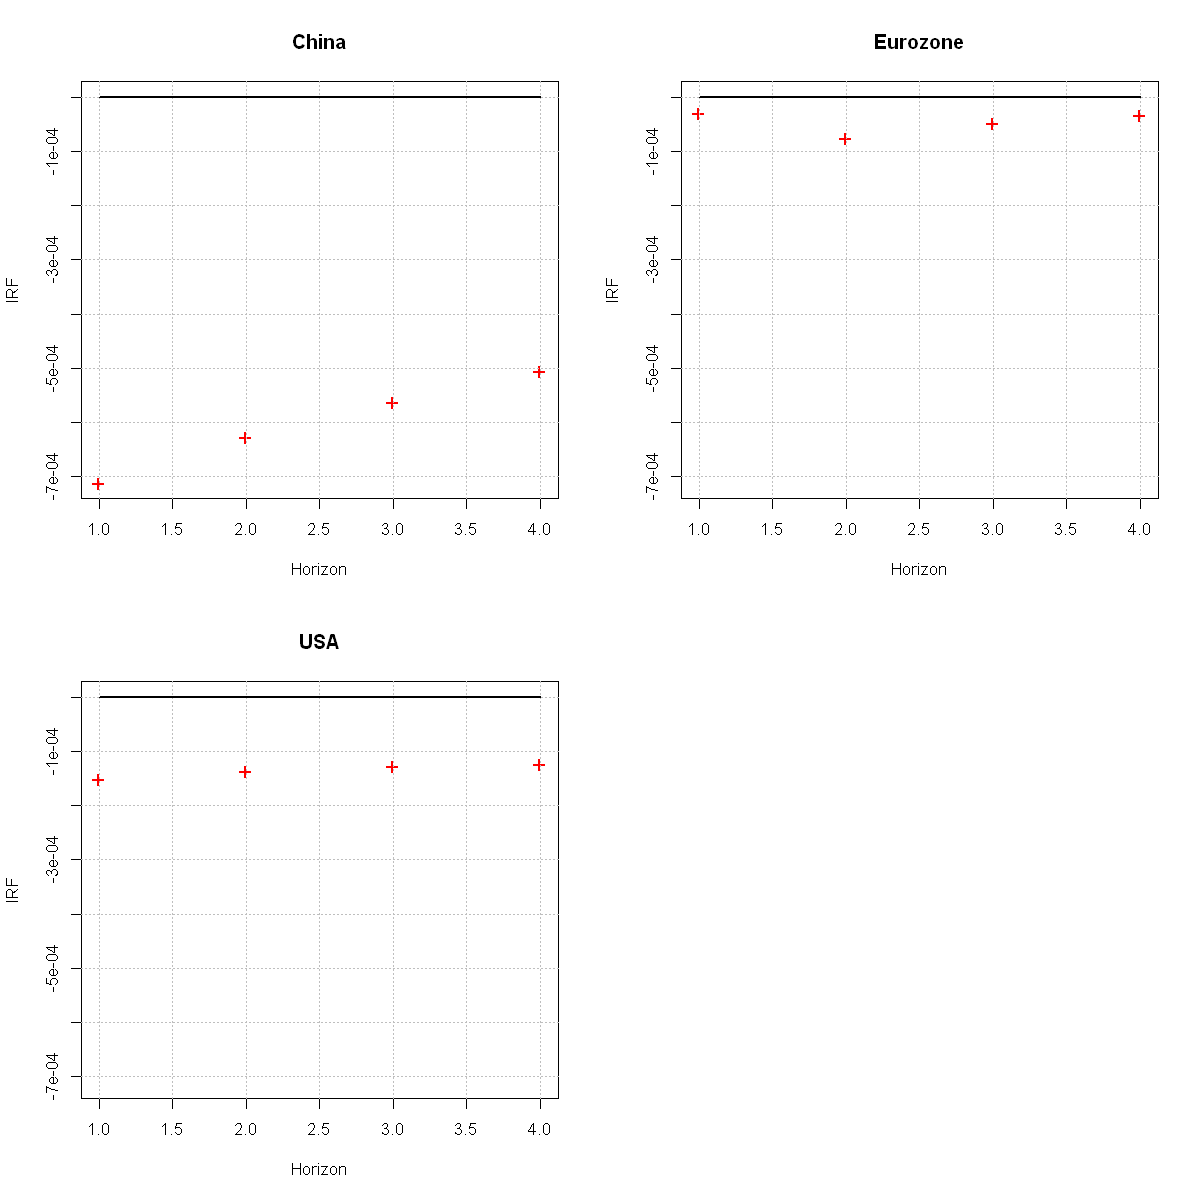

In [15]:
# test total calcul IRF pour ordre 7 et horizon 4
p_order= 1
horizon= 4
e= c(-0.08, 0, 0)

# Permet de calculer la matrice phi, de l'ordre 1 à p, pour faire la transformation var p à var 1
stock_test_phi= phi_transforma(data_matrix, p_order)
# Permet de calculer et de resizer le vecteur phi0 pour l'adapter à la transformation var p à var 1
phi_zero= phi_zero_transforma(data_matrix, p_order)
# Permet de calculer l'erreur dans le cas d'un var p (marche aussi en var 1)
computed_error= error_transformation(data_matrix, p_order, stock_test_phi, phi_zero)
# Calcul de la matrice p qui permet d'orthogonaliser mon système
p_mat= compute_choleski_p(data_matrix, computed_error, p_order)
# Calcul des chocs  jusqu'à l'horizon souhaité
irf_calculated= irf_compute(data_matrix, p_order, stock_test_phi, horizon, e, p_mat)

# On plot l'IRF que nous venons de calculer
fig(10, 10)
print("Choc de -8% dans l'économie chinoise")
plot_irf(data_matrix, irf_calculated)

Le premier choc que l'on simule est celui d'une croissance négative en Chine de 8%. On sait que la Chine est l'usine du monde. On se rend bien compte actuellement (crise du COVID) que si la Chine stoppe son appareil productif, le monde arrête de consommer. Voir l'impact d'un tel choc sur les autres pays, notamment développés est donc d'un intérêt tout particulier. 

Dans notre cas, on voit bien que ce choc négatif sur la Chine ne semble pas se résorber sur les 4 périodes que l'on a considéré. Attention néanmoins, peut-être que les intervalles de confiance sont très larges et donc que ce choc se résorbe au bout d'une période ; on ne pourra pas le savoir. En tout cas ce qui est sûr c'est que ce choc impact fortement la Chine (normal!) mais aussi les Etats-Unis et la Zone Euro.

Dans le cas des Etats-Unis, le choc est négatif et constant sur les 4 périodes que nous avons considéré (soit 1 an). De plus, on observe le même phénomène pour la Zone Euro. A vrai dire, nous avons l'impression que le choc de croissance de l'économie chinoise modifie durablement l'équilibre de croissance de la Zone Euro et des Etats-Unis.

C'est ce que nous avons cherché à observer avec le calcul du choc sur 24 périodes, et on se rend compte, que pour les Etats-Unis, ce choc a bien modifié durablement la structure de son économie avec un choc négatif et constant. Mais ce n'est pas le cas pour la Zone Euro. Enfin, même la Chine a du mal à se remettre du choc.

Attention, nous n'avons pas tracé les intervalles de confiance, donc nous ne sommes pas en mesure de vérifier la fiabilité des résultats. Dans le cas des Etats-Unis, il se pourrait même que l'intervalle de confiance soit tellement large que le choc soit tout le temps nul !

En tout cas, on observe bien l'interconnexion des économies, et la diffusion des chocs d'un pays vers les autres.

[1] "Choc de -8% dans l'économie chinoise sur 24 périodes"


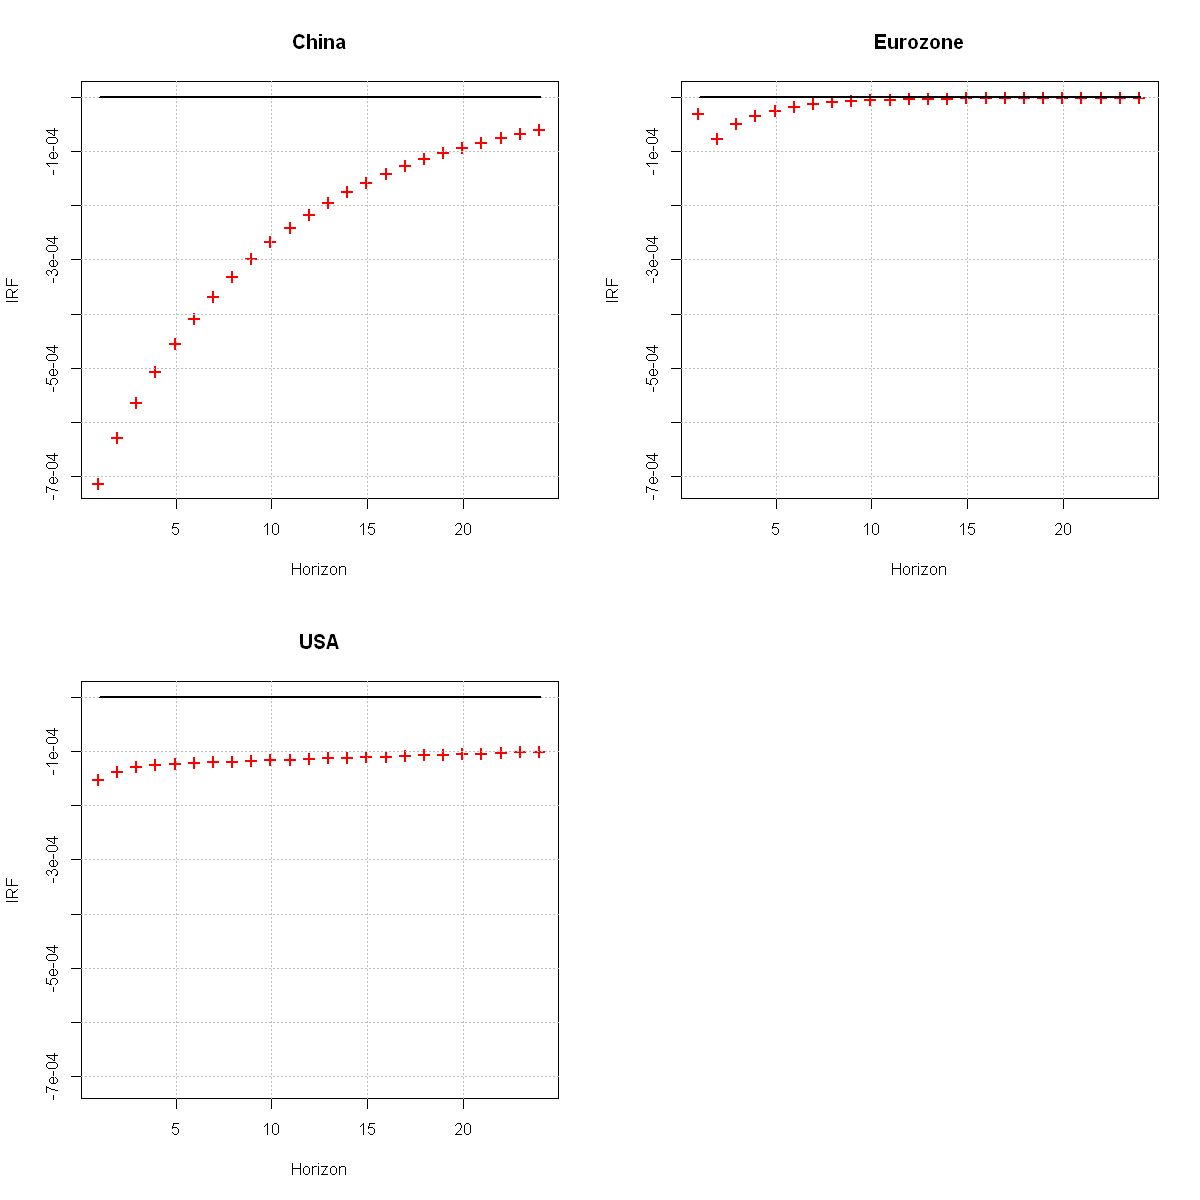

In [16]:
horizon= 24
e= c(-0.08, 0, 0)
irf_calculated= irf_compute(data_matrix, p_order, stock_test_phi, horizon, e, p_mat)

# On plot l'IRF que nous venons de calculer
fig(10, 10)
print("Choc de -8% dans l'économie chinoise sur 24 périodes")
plot_irf(data_matrix, irf_calculated)

[1] "Choc de -5% dans l'économie américaine"


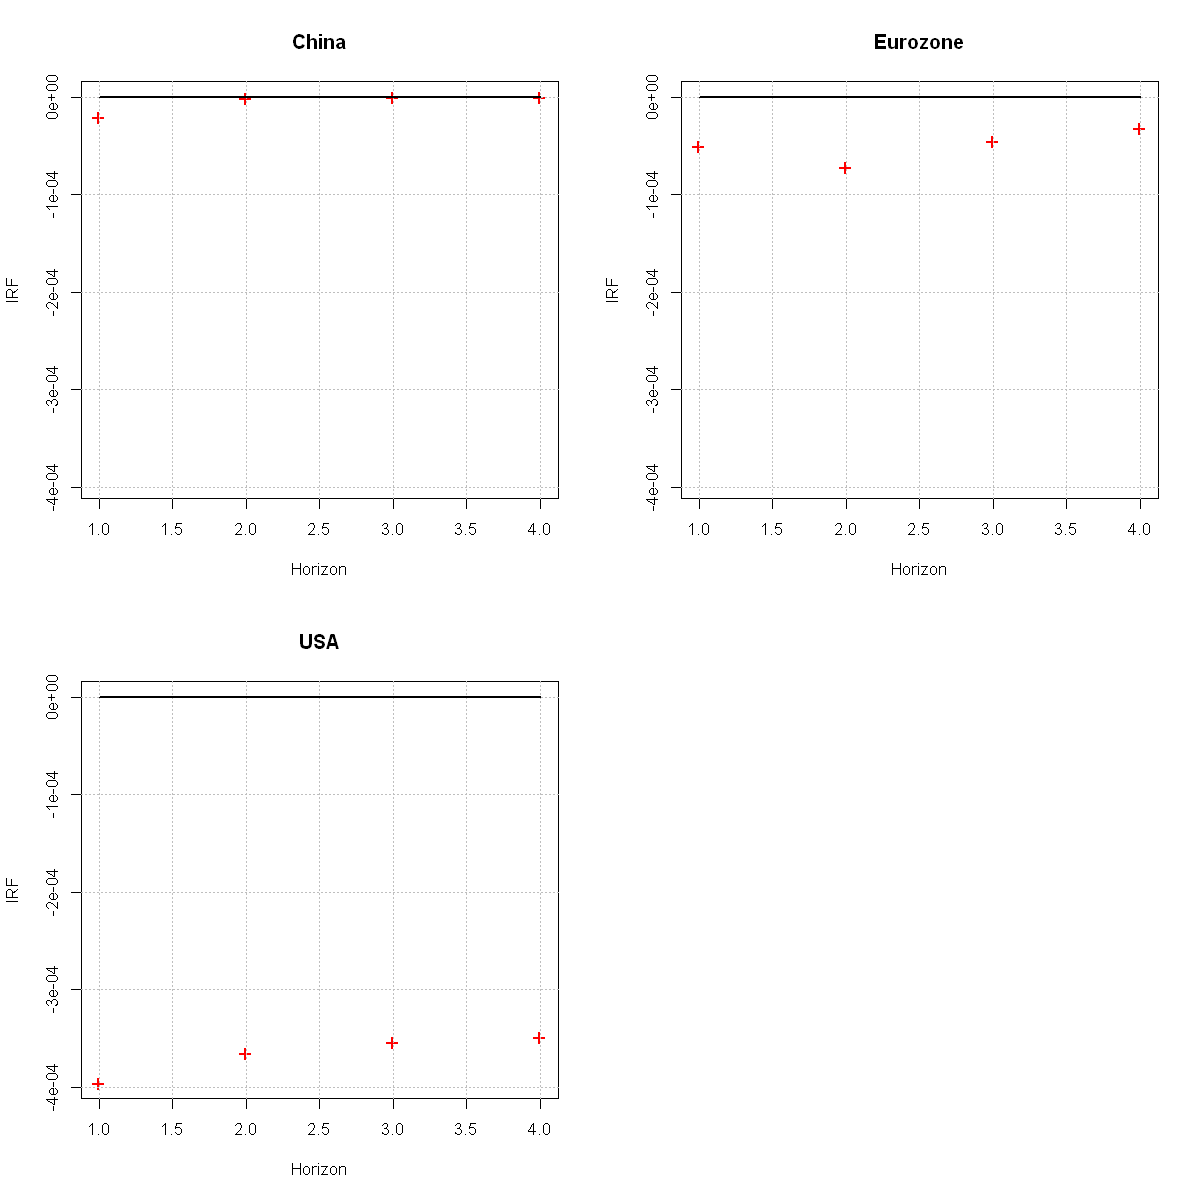

In [17]:
horizon= 4
e= c(0, -0.05, 0)
irf_calculated= irf_compute(data_matrix, p_order, stock_test_phi, horizon, e, p_mat)

# On plot l'IRF que nous venons de calculer
fig(10, 10)
print("Choc de -5% dans l'économie américaine")
plot_irf(data_matrix, irf_calculated)

Voici un choc négatif de 5% sur la croissance américaine. Comme convenu, ce choc affecte sur 1 an l'économie américaine. Et quand on observe la diffusion du choc sur 24 trimestres, on remarque que l'impact ne disparaît pas au cours du temps. C'est probablement lié au fait que pour une économie développée, un choc de -5% est un énorme impact, et que ce dernier a dû profondément changer la structure de l'appareil productif américain. Ce qui peut sembler déroutant étant donné que l'économie américaine est une économie très libérale, par exemple son marché de l'emploi est très flexible par rapport à celui de la France, ce qui est censé lui permettre de se remettre plus rapidement d'une crise économique comme celle d'un gros choc négatif de croissance. Soit l'économie américaine a en effet énormément de mal à se remettre d'un choc aussi important, soit notre modèle est mal spécifié, et donc il aurait fallu soit augmenter l'ordre du VAR, soit, lors de la construction de nos fonctions de réponses, positioner la série des Etats-Unis différemment (actuellement deuxième position).

Pour la Chine cependant, le choc ne semble impacter négativement que la première période. En effet, pour toutes les autres périodes, le choc est nul ; ce que l'on peut aussi voir sur un choc diffusé sur 24 périodes ci-dessous. 

Pour l'économie de la Zone Euro, on remarque le même phénomène que pour un choc provenant de la Chine avec un pic négatif à la deuxième période (probablement significatif), puis une convergence vers 0. La Zone Euro reçoit pleinement l'impact d'un choc avec un décalage de 1 trimestre par rapport aux deux autres économies. Puis le choc se nullifie au bout de 10 trimestres.

[1] "Choc de -5% dans l'économie américaine sur 24 périodes"


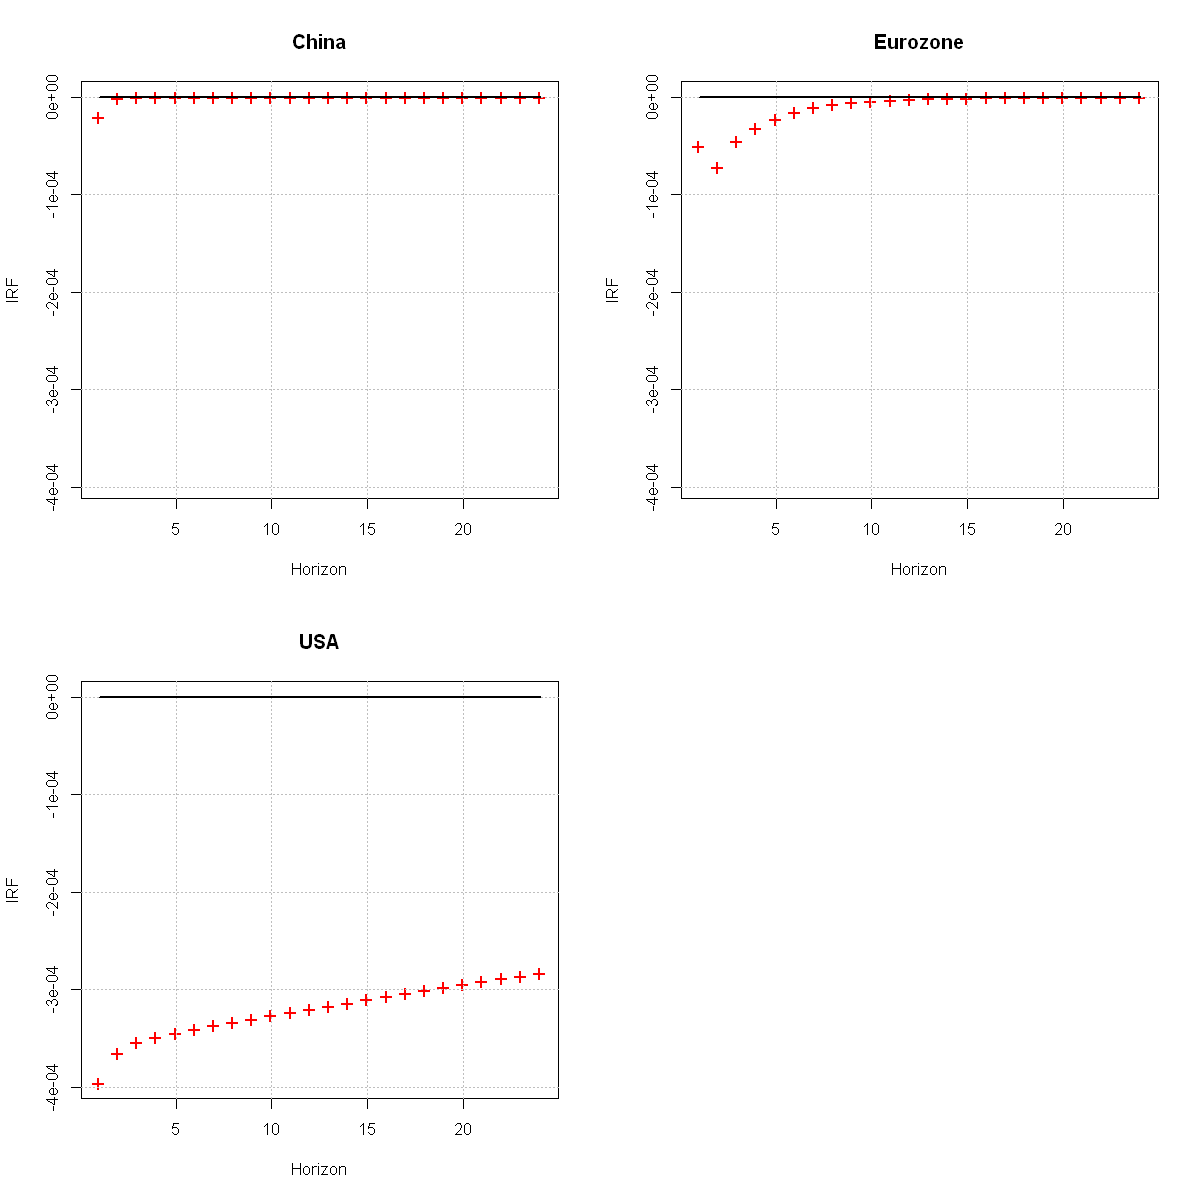

In [18]:
horizon= 24
e= c(0, -0.05, 0)
irf_calculated= irf_compute(data_matrix, p_order, stock_test_phi, horizon, e, p_mat)

# On plot l'IRF que nous venons de calculer
fig(10, 10)
print("Choc de -5% dans l'économie américaine sur 24 périodes")
plot_irf(data_matrix, irf_calculated)

[1] "Choc de -5% dans l'économie de la Zone Euro"


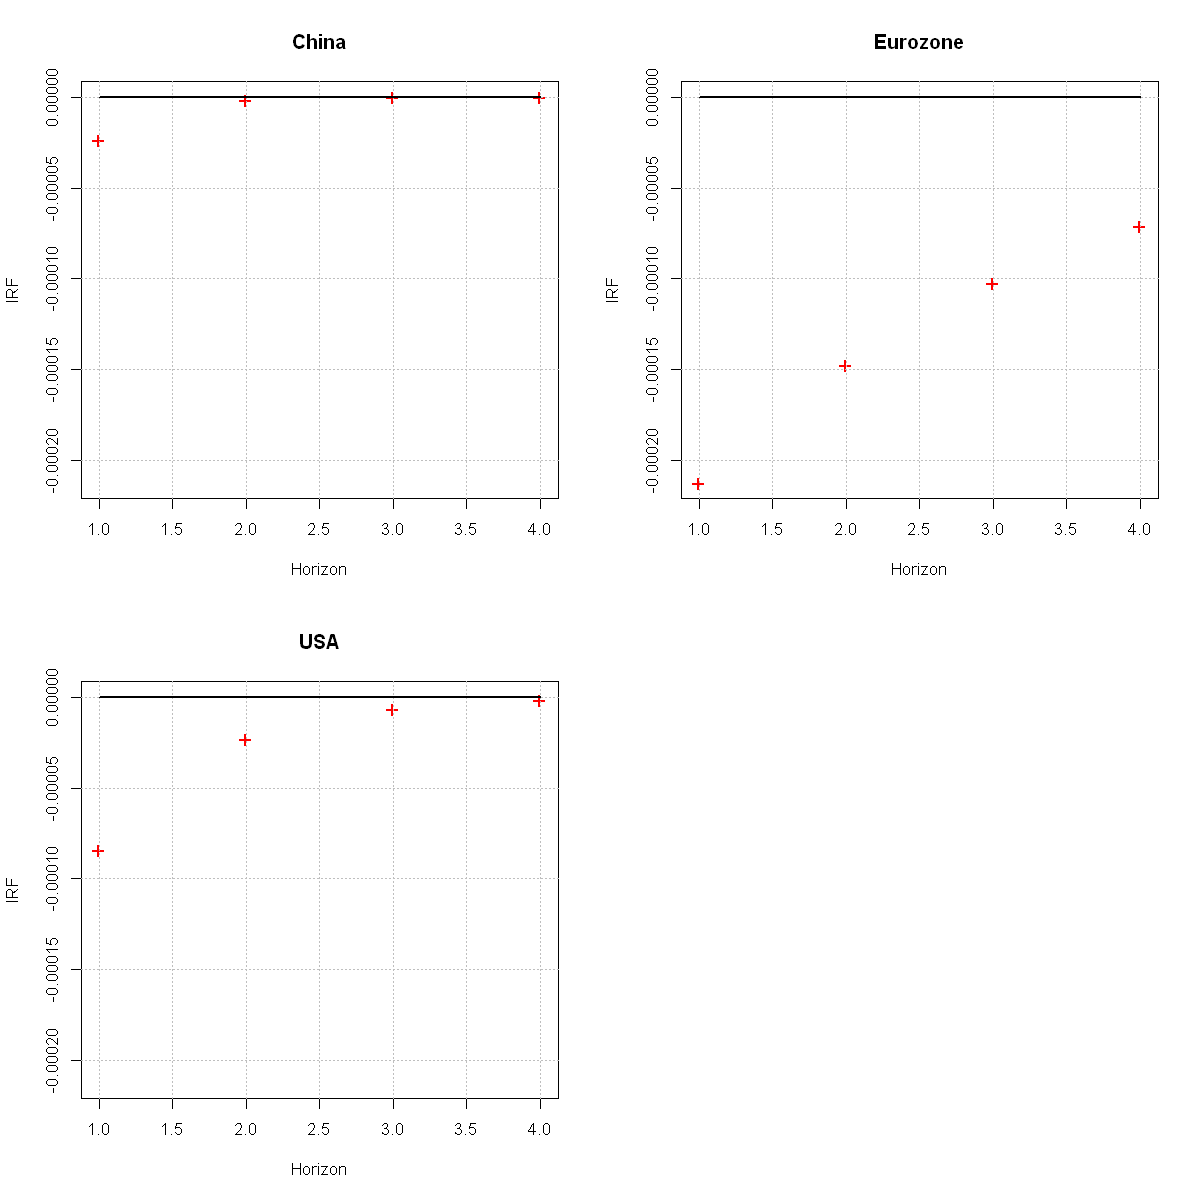

In [19]:
horizon= 4
e= c(0, 0, -0.05)
irf_calculated= irf_compute(data_matrix, p_order, stock_test_phi, horizon, e, p_mat)

# On plot l'IRF que nous venons de calculer
fig(10, 10)
print("Choc de -5% dans l'économie de la Zone Euro")
plot_irf(data_matrix, irf_calculated)

Enfin, voici l'impact d'un choc négatif de 5% sur l'économie de la Zone Euro. Dans un premier temps, on remarque que pour la Zone Euro, le choc est diffu au cours du temps, car plus les trimestres passent, moins le choc impacte négativement l'économie de la Zone Euro. Vers le 15ème trimestre, son impact est nullifié.

A propos de la réception de ce choc par l'économie chinoise, il est négatif et on se rend compte qu'il disparaît après une période, (3 périodes pour les Etats-Unis). 

Ce choc est à la fois rapidement assimilié par la Zone euro, mais aussi pour les deux autres pays.

[1] "Choc de -5% dans l'économie américaine"


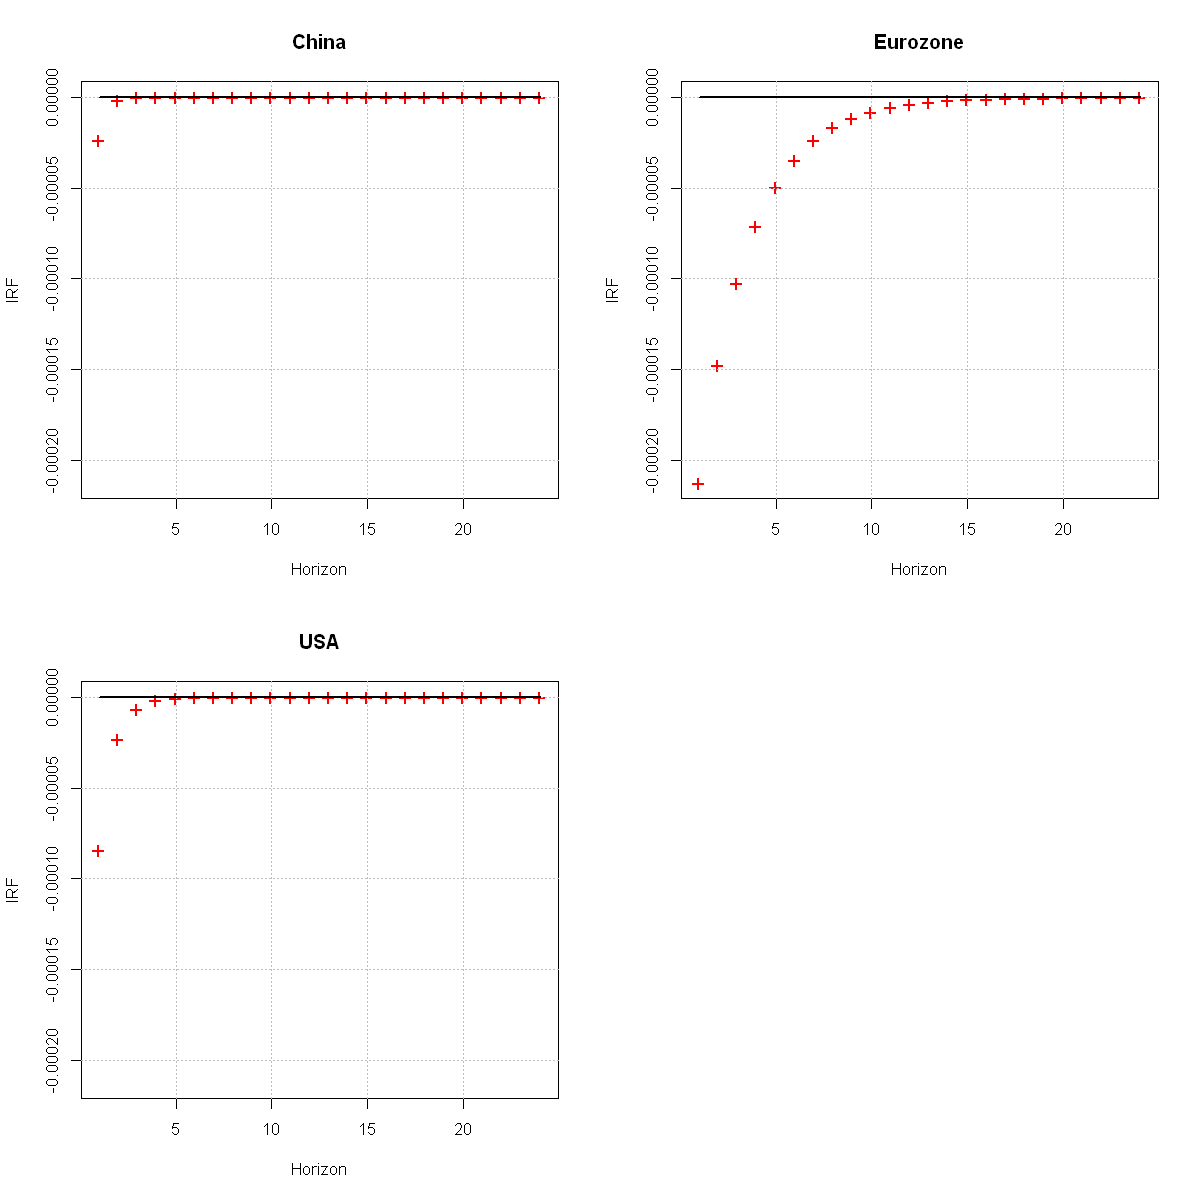

In [20]:
horizon= 24
e= c(0, 0, -0.05)
irf_calculated= irf_compute(data_matrix, p_order, stock_test_phi, horizon, e, p_mat)

# On plot l'IRF que nous venons de calculer
fig(10, 10)
print("Choc de -5% dans l'économie américaine")
plot_irf(data_matrix, irf_calculated)

<a id= "4"></a>

### 4). Why is it important to estimate these second-round effects today?

Dans quelle drôle d'époque vivons-nous ! Nous avons la possibilité d'acheter un objet provenant de Chine, tout en regardant une série américaine, bien au chaud dans notre lit à Paris. Dans cette drôle d'époque, les économies du monde entier sont interconnectées. Une catastrophe en Chine aura forcément un impact sur toutes les autres économies du monde. En effet, la Chine est à la fois l'usine du monde mais aussi un important partenaire commercial de beaucoup de pays, développés ou non. Et c'est la même chose pour les Etats-Unis et la Zone Euro.


Prenons comme exemple une politique de relance keynesienne : celle de Mauroy de 1981. Cette politique peut se résumer par une hausse des salaires en France (SMIC, fonctionnaire). Elle s'est soldé par un échec et une hausse des déficits budgétaires et extérieurs, car isolée, cette politique n'avait pas pris en considération le fait que l'argent allait permettre d'acheter des biens produits à l'étranger (le fameux lecteur de cassette nippon) et non en France. Si on analysait ce choc de demande que représente la politique de Mauroy, peut-être pourrions nous remarquer un choc positif sur le taux de croissance japonais. C'est très similaire à la théorie du battement d'ailes d'un papillon.

Voila pourquoi, construire des fonctions de réponse généralisée est nécessaire et si intéressant pour les économistes. C'est pour cela que nous avons voulu savoir si une récession importante dans un pays pouvait impacter l'économie d'un autre pays et pendant combien de temps. Plusieurs faits ont été soulevés par l'analyse des fonctions de réponse. Premièrement, une récession en Chine semble impacter sur plus de 24 trimestres le taux de croissance des Etats-Unis (avec un choc négatif constant). Le fait que la Chine soit un important partenaire commercial doit expliquer le puissant impact de la récession chinoise. 
La Zone Euro s'en remet beaucoup plus facilement, ce qui est étonnant, car comme les Etats-Unis, l'empire du Milieu est le deuxième exportateur de la Zone Euro. Evidemment, il n'y a pas que des liens d'exportation / importation qui relient des pays, on pourrait par exemple considérer la migration des personnes, mais aussi des capitaux pour expliquer cette différence. Ou sinon, c'est la réponse de l'Oncle Sam qui est aberrante, car si on regarde sur 24 périodes, la réponse de la Zone Euro disparaît au bout de 10 périodes, ce qui semble plutôt cohérent. De plus, nous savons par expérience que le marché du travail américain est beaucoup plus flexible que dans certain pays d'Europe ; par exemple on observait en 2008 un taux de chômage de près de 10%, contre 4% 2 ans plus tard. Cela lui permet de faire passer la tempête et de faire survivre ses entreprises plus longtemps. C'est aussi un de ses leviers pour générer une reprise rapide. C'est pourquoi une modification structurelle de l'économie américaine suite à une crise chinoise semble peu probable : l'intervalle de confiance que nous n'avons pas tracé doit assurément nullifié le choc sur plus de 10 périodes, tout comme en Europe.

Deuxièmement, nous avons simuler un choc de -5% dans la croissance américaine, et nous avons observé le même problème qu'avec la réponse du choc chinois : le choc résonne sur toutes périodes que l'on trace (24 trimestres). La réponse de l'Empire du Milieu est pour le coup intéressante car le choc n'impacte que le premier trimestre de façon négative, puis disparaît. Enfin pour la Zone Euro, le choc est négatif et ceux jusqu'à 10 périodes environ.

Cette réponse négative chinoise au choc américain semble similaire à un choc qui apparaîtrait en Zone Euro. Etant donné que l'Oncle Same et la Zone euro sont des marchés privilégiés pour la Chine, ce n'est pas étonant de voir apparaître une réponse négative. Mais, le fait qu'il disparaisse après 1 trimestre semble nous signaler que la Chine dissipe rapidement l'écho du choc, soit en ayant la possibilité d'exporter des biens ailleurs, soit les pays en crises ne penvent se passer des biens / capitaux chinois.

Pour conclure, la situation actuelle nous semble bien différente de ces simulations étant donné que la crise sanitaire est un choc qui touche tous les pays, mais de façon retardée : la Chine en premier, l'Europe en deuxième puis finalement les Etats-Unis. En plus du choc, nous devons subir les echos des chocs (les réponses) : la crise en Chine a impacté le tourisme en France, le secteur du luxe, et donc bien avant de nous même subir la crise de plein fouet, nous y avons goûter par l'intermédiaire de la crise en Chine. C'etait alors la réponse de la France au choc de la crise de l'Empire du Milieu. Mais la France est aussi touchée par la crise sanitaire (télétravail , chômage partiel, confinement) ce qui rend à notre sens ardu de modéliser la crise et sa raisonnance avec un modèle VAR et ses fonctions de réponses.

<a id= "a"></a>

### Annexes

Voici notre tentative pour créer les intervalles de confiance pour les fonctions de réponses généralisées à l'aide de block bootstrapping.

In [21]:
# calculons les intervalles de confiances pour les IRF
# on va utiliser une méthode de block bootstrap
# on va récupérer 95 % random lines de notre matrice
# calculer les coeff, l'erreur centrée et recalculer les IRF
# on va garder pour chaque période le max et le min pour chaque pays

block_bootstrap= function(X, ic){
    # Permet de générer un échantillon block bootstrapped
    # Le block bootstrapping permet de faire du bootstrapping sur une série, et donc en récupérant
    # des lignes proches.
    # Avec un bootstrap classique, la série temp perdrait sa notion de temps et d'autocorr (lien intertemporel)
        # X désigne notre dataset
        # ic désigne la part des lignes du dataset que l'on va prendre 
        # pour générer ce block bootstrapped
    m= nrow(X)
    n= ncol(X)
    ic= 95
    num= floor(m*ic/100)

    # permet de block bootstrap ma série
    stocked_data= matrix(0, 1, n, byrow= T)
    for (i in 1:num){
        # On va récupérer 2 lignes avant et après la ligne que l'on a sélectionné et les ajouter
        # à la suite
        random_id= floor(runif(1, 3, m - 2)) # on commence à 3 car on récupère 2 index en amont
                                             # et on finit à m - 2 car on récupère 2 lignes 
                                             # après l'id sélectionné aléatoirement
        before_1= random_id -2
        before= random_id - 1
        after= random_id + 1
        after_1= random_id + 2

        select_val= c(before_1, before, random_id, after, after_1)
        data_sample= X[select_val, ]

        stocked_data= rbind(stocked_data, data_sample)
    }
    stocked_data= stocked_data[-1, ] # supprime la première ligne
    
    return (stocked_data)
}
head(block_bootstrap(data_matrix, 95))

China,USA,Eurozone
0.091,0.053,0.045
0.088,0.041,0.039
0.075,0.030,0.034
0.095,0.023,0.031
0.086,0.011,0.023
0.103,0.044,0.019


In [22]:
# p_order= 2
# horizon= 4
# e= c(-0.08, 0, 0)

# # on génère le dataset bootstrap
# data_bootstraped= block_bootstrap(data_matrix, 95)
# # Permet de calculer la matrice phi, de l'ordre 1 à p, pour faire la transformation var p à var 1
# stock_test_phi= phi_transforma(data_bootstraped, p_order)
# # Permet de calculer et de resizer le vecteur phi0 pour l'adapter à la transformation var p à var 1
# phi_zero= phi_zero_transforma(data_bootstraped, p_order)
# # Permet de calculer l'erreur dans le cas d'un var p (marche aussi en var 1)
# computed_error= error_transformation(data_bootstraped, p_order, stock_test_phi, phi_zero)

# ############################################################
# # on centre notre erreur
# mean_error= t(as.matrix(colMeans(computed_error)))
# mean_error_resized= matrix(mean_error, nrow(computed_error), ncol(mean_error), byrow= T)
# centr_error= computed_error - mean_error_resized
# centr_error_shuffle= centr_error[sample(nrow(centr_error)), ]

# n= ncol(data_bootstraped)
# propre_error= centr_error_shuffle[, c(1:n)]

# # ajout de l'erreur à notre sample
# prop_data_boots= data_bootstraped[-c(1:p_order), ] + propre_error
# #############################################################

# # On va à partir du dataset prop_data_boots